# Intro

## The Blocker Fraud Company

**Blocker Fraud Company** is a specialized company in fraud detection on financial transactions through mobile devices. It has the "Blocker Fraud" service, which guarantee the block of fraudulent transactions.

The company business model is service type, with monetization made by performance of the provided service. The user pay a fixed fee on the fraud detection success.

## Expansion Strategy in Brazil

Aiming to expand business in Brazil it has adopted the following strategy:

- The company will receive 25% of the value of each transaction detected as *fraud*.
- The company will receive 5% of the value of each transaction detected as *fraud*, but the transaction is *legitimate*.
- The company will return 100% of the value to the customer, for each transaction detected as legitimate, however a transaction is a fraud.

## Context

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behavior to later evaluate the performance of fraud detection methods.

## Content

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

## Goal

1. What is the model's *precision* and *accuracy*?
2. How reliable is the model in classifying transactions as *legitimate* or *fraudulent*?
3. What is the expected billing by the company if we classify 100% of data transactions with the model?
4. What is the loss expected by company in case of model failure ?
5. What is the profit expected by the **Blocker Fraud Company** when using model?
> Disclaimer: The following context is completely fictional, the company, the context, the CEO and the business questions.

## Data

Data provided by Kaggle: [Synthetic Financial Datasets for Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)

## Analysis

This solution will use descriptive statistics and data visualization to find key figures in understanding the distribution, count, and relationship between variables. Since the goal of the project to make predictions on the fraud's detection, classification algorithms from the supervised learning family of machine learning models will be implemented.

## Evaluation

The project will conclude with the evaluation of the machine learning model selected with a validation data set. The output of the predictions can be checked through a confusion matrix, and metrics such as accuracy, precision, recall, F1 and Kappa scores.

# 0.0. Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

#Data text
import inflection

# Statistics
from scipy import stats
from pandas_profiling import ProfileReport

# Load images
from IPython.display import Image

# Warning
import warnings
warnings.filterwarnings( 'ignore' )

## 0.1. Help Functions

# 1.0. Data

## 1.1. Load the Data

In [2]:
df = pd.read_csv('data\PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1.2. Knowing the Data

### 1.2.1. Shape

In [3]:
print('The shape of dataset is:')
df.shape

The shape of dataset is:


(6362620, 11)

### 1.2.2. Type and Structure

In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


* It's a huge dataset with memory usage more than 534.0 MB.
* No null values.
* dtypes: float64(5), int64(3), object(3)

### 1.2.3. Columns Description
| Feature        | Description                                                  |
| :------------- | :----------------------------------------------------------- |
| step           | maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation). |
| type           | Transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER) |
| amount         | amount of the transaction in local currency                  |
| nameOrig       | customer who started the transaction                         |
| oldbalanceOrg  | initial balance before the transaction                       |
| newbalanceOrig | new balance after the transaction                            |
| nameDest       | customer who is the recipient of the transaction             |
| oldbalanceDest | initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants) |
| newbalanceDest | new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants) |
| isFraud        | This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system |
| isFlaggedFraud | The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200K in a single transaction |

## 1.3. Dtypes changes
In order do optimize the RAM usage, we're going to specify the data types that we want for each feature

In [5]:
# defines a dictionary of dtypes for each feature
feature_dtypes = {'step': 'int16',
                  'type': 'category',
                  'amount': 'float32',
                  'nameOrig': 'object',
                  'oldbalanceOrg': 'float32',
                  'newbalanceOrig': 'float32',
                  'nameDest': 'object',
                  'oldbalanceDest': 'float32',
                  'newbalanceDest': 'float32',
                  'isFraud': 'uint8',
                  'isFlaggedFraud': 'uint8'}

# Load the data
df_op = pd.read_csv('data\PS_20174392719_1491204439457_log.csv', dtype=feature_dtypes)

In [6]:
df_op.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   step            6362620 non-null  int16   
 1   type            6362620 non-null  category
 2   amount          6362620 non-null  float32 
 3   nameOrig        6362620 non-null  object  
 4   oldbalanceOrg   6362620 non-null  float32 
 5   newbalanceOrig  6362620 non-null  float32 
 6   nameDest        6362620 non-null  object  
 7   oldbalanceDest  6362620 non-null  float32 
 8   newbalanceDest  6362620 non-null  float32 
 9   isFraud         6362620 non-null  uint8   
 10  isFlaggedFraud  6362620 non-null  uint8   
dtypes: category(1), float32(5), int16(1), object(2), uint8(2)
memory usage: 248.8+ MB


- The memory usage reduce to 248.8.0 MB.
- Still no null values.
- dtypes: category(1), float32(5), int16(1), object(2), uint8(2)

## 1.4. Rename Columns

In [7]:
# Using underscore
cols_list = []
for x in df_op.columns:
    columns_new = inflection.underscore(x)
    cols_list.append(columns_new)

In [8]:
df_op.columns = cols_list
df_op = df_op.rename(columns={'oldbalance_org': 'oldbalance_orig' })
df_op

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,0,0
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,0,0
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,1,0
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,1,0
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,1,0
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,1,0
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,1,0
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,1,0


## 1.6. Descriptive Statistics

### 1.6.1. Numerical Attributes

In [9]:
# Selecting numerical attributes
num_attr = df_op.select_dtypes(exclude=['category', 'object'])

# Describe
describe = num_attr.describe().T

describe['range'] = (num_attr.max() - num_attr.min()).tolist()
describe['unique val.'] = num_attr.nunique()
describe['variation coefficient'] = np.round((num_attr.std() / num_attr.mean()), 4).tolist()
describe['skew'] = np.round(num_attr.skew(), 4).tolist()
describe['kurtosis'] = np.round(num_attr.kurtosis(), 4).tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,unique val.,variation coefficient,skew,kurtosis
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.000000,239.000000,3.350000e+02,743.0,742.0,743,0.5848,0.3752,0.3291
amount,6362620.0,1.779883e+05,5.991358e+05,0.0,13389.570312,74871.937500,2.087215e+05,92445520.0,92445520.0,5236933,3.3662,30.9939,1797.9567
oldbalance_orig,6362620.0,8.246191e+05,2.831753e+06,0.0,0.000000,14208.000000,1.073152e+05,59585040.0,59585040.0,1834373,3.4340,5.2491,32.9649
newbalance_orig,6362620.0,8.503204e+05,2.862818e+06,0.0,0.000000,0.000000,1.442584e+05,49585040.0,49585040.0,2663280,3.3668,5.1769,32.0670
oldbalance_dest,6362620.0,1.097866e+06,3.369338e+06,0.0,0.000000,132705.664062,9.430367e+05,356015904.0,356015904.0,3532215,3.0690,19.9218,948.6741
newbalance_dest,6362620.0,1.221764e+06,3.629806e+06,0.0,0.000000,214661.445312,1.111909e+06,356179264.0,356179264.0,3474507,2.9710,19.3523,862.1565
is_fraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.000000,0.000000,0.000000e+00,1.0,1.0,2,27.8155,27.7795,769.7030
is_flagged_fraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.000000,0.000000,0.000000e+00,1.0,1.0,2,630.6051,630.6036,397659.0625


Exception of `step` feature, most of the numerical attributes shows:

* High skew.
* High kurtosis.
* High variation.

### 1.6.2. Categorical Attributes

In [10]:
cat_attr = df_op.select_dtypes(include=['category', 'object'])
cat_attr.describe().T

,count,unique,top,freq
type,6362620,5,CASH_OUT,2237500
name_orig,6362620,6353307,C1065307291,3
name_dest,6362620,2722362,C1286084959,113


## 1.7. Checkpoint A

In [11]:
# Saving optimize dataset
df_op.to_csv('dataset\df1.csv', index=False)

# 2.0. Hypotheses Creation

## 2.1. Mind Map Hypotheses

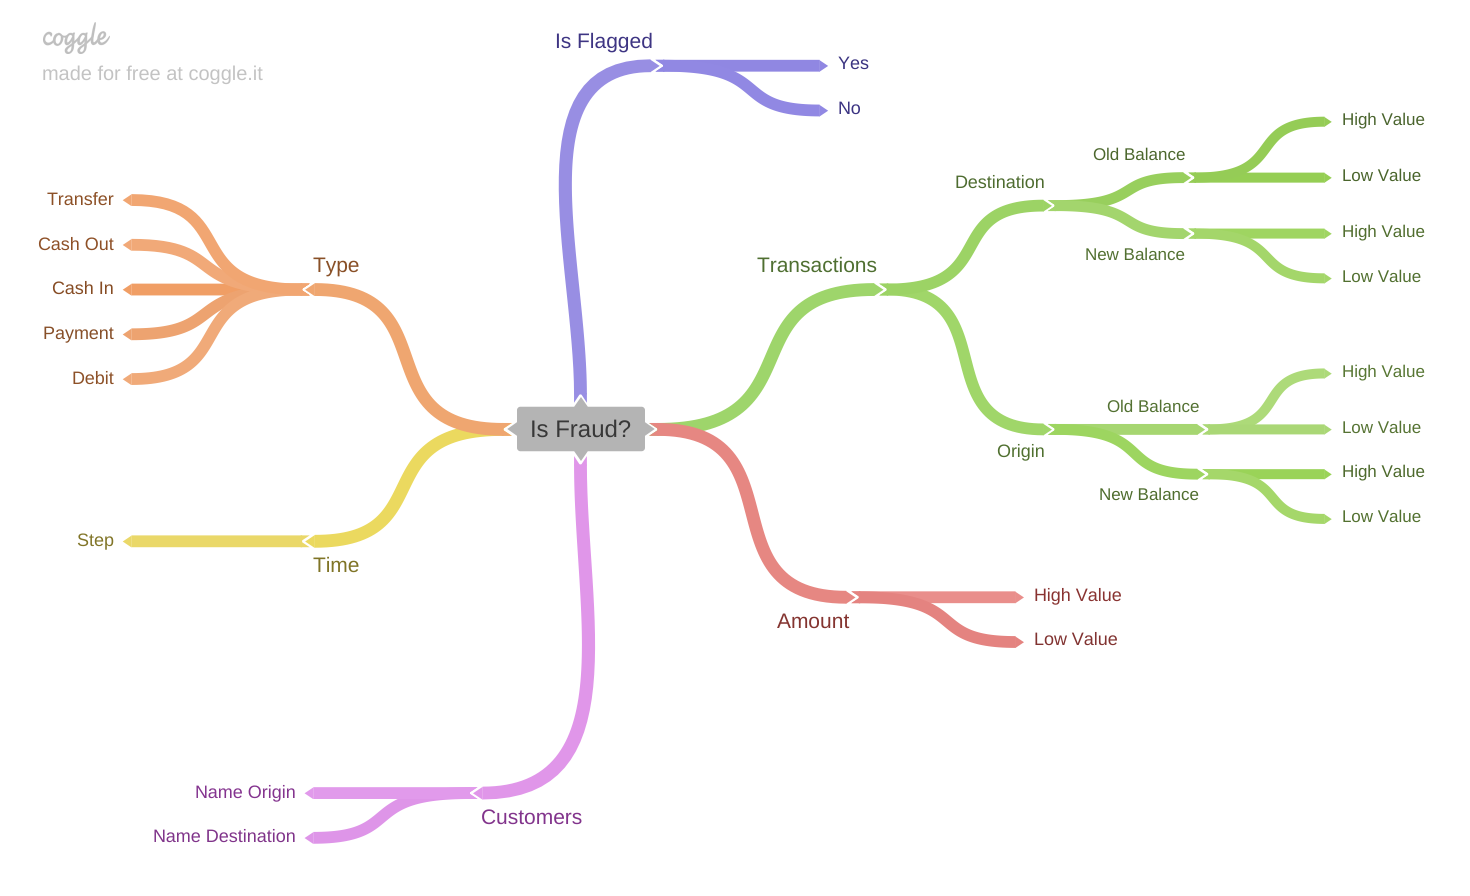

In [12]:
Image('image\mindmap.png')

## 2.2. Hypotheses Creation

### 2.2.1. Type

h1. Frauds occur with 3 types of transactions.

### 2.2.2. Amount

h1. Fraud occur with low values amounts.

### 2.2.3. Transactions

h1. Fraud occur with high values of old balance origin.

h2. Fraud occur with new balance origin is equal zero.

h3. Fraud occur with low values old balance destination.

h4. All fraudulent transaction occur with new receiver balance  equal zero.

### 2.2.4. Customers

h1. Customer to customer transactions represent 50% of the total fraudulent transactions.

h2. Merchant receiver represents 40% of the total fraudulent transactions.

### 2.2.5. Time

h1. Most Fraud occurs between days 10 and 20.

### 2.2.6. Is Flagged

h1. All flagged frauds represent 90% of frauds transactions.

## 2.3. Hyphoteses List

| #    | HYPOTHESES                                                   |
| ---- | ------------------------------------------------------------ |
| h1   | Frauds occur with 3 types of transfers.                      |
| h2   | Fraud occur with low values amounts.                         |
| h3   | Fraud occur with high values of old origin balance.          |
| h4   | Fraud occur with new balance origin is equal zero.           |
| h5   | Fraud occur with low values old balance destination.         |
| h6   | All fraudulent transaction occur with new receiver balance equal zero. |
| h7   | Customer to customer transactions represent 50% of the total fraudulent transactions. |
| h8   | Merchant receiver represents 40% of the total fraudulent transactions. |
| h9   | Most Fraud occurs between days 10 and 20.                                 |
|h10  | All flagged frauds represent 90% of frauds transactions. |